# SVCTEST hunt

This notebook helps to collect all SVCTEST (svctest.exe) and SERVICES service (services.exe) process executions in order to find suspicious activity.

As an example on how to leverage the data retrieved we first look at overal SVCTEST executions (grouped by process:creator_user_ref.user_id (username), path), then focus on Windows .bat script executions.

In [1]:
from pyclient.stix_shifter_dataframe import StixShifterDataFrame
from dateutil import parser


In [2]:
carbon_black_stix_bundle = 'https://raw.githubusercontent.com/opencybersecurityalliance/stix-shifter/develop/data/cybox/carbon_black/carbon_black_observable.json'
sb_config = {
    'connection': {
        "host": carbon_black_stix_bundle,
        "port": 443
    },
    'configuration': {
        "auth": {
            "username": '',
            "password": ''
        }
    },
    'data_source': '{"type": "identity", "id": "identity--3532c56d-ea72-48be-a2ad-1a53f4c9c6d3", "name": "stix_boundle", "identity_class": "events"}'
}

In [3]:
def get_duration(duration):
    days, seconds = duration.days, duration.seconds
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{days}d {hours}h {minutes}m {seconds}.{duration.microseconds//1000}s"

In [4]:
ssdf = StixShifterDataFrame()
ssdf.add_config('stix_bundle', sb_config)

svctest_query = "[process:name='svctest.exe']"
services_query = "[process:parent_ref.name='services.exe']"

df1 = ssdf.search_df(query=svctest_query, config_names=['stix_bundle'])
df2 = ssdf.search_df(query=services_query, config_names=['stix_bundle'])

In [5]:
df1['desc'] = 'svctest'
df1['type'] = 'process'
df1['first_observed'] = df1['first_observed'].map(lambda x: parser.isoparse(x))
df1['last_observed'] = df1['last_observed'].map(lambda x: parser.isoparse(x))
df1['duration'] = df1['last_observed'] - df1['first_observed']
df1['duration'] = df1['duration'].map(lambda dur: get_duration(dur))


df2['desc'] = 'svctest'
df2['type'] = 'process'
df2['first_observed'] = df2['first_observed'].map(lambda x: parser.isoparse(x))
df2['last_observed'] = df2['last_observed'].map(lambda x: parser.isoparse(x))
df2['duration'] = df2['last_observed'] - df2['first_observed']
df2['duration'] = df2['duration'].map(lambda dur: get_duration(dur))

In [6]:
df1.shape, df2.shape

((31, 32), (21, 32))

In [7]:
# Helper functions to replace and extract strings
import re

def replace_string(data, search, replace):
    return data.replace(search, replace)

def extract_string(data, regex, group):
    try:
        pattern = re.compile(regex)
        matches = pattern.search(data)
        return matches.group(group)
    except:
        return ''

# Clean up cmdline fields that are missing a space before c:\
df1['cmdline'] = df1['process:command_line'].apply(replace_string, args=['c:\\', ' c:\\'])
# Extract .bat file name from cmdline field
df1['cmdline_bat'] = df1['process:command_line'].apply(extract_string, regex=r'\\([0-9a-zA-Z_-]*\.bat)', group=1)
# Extract several variants of hostname or IP address from cmdline field
df1['cmdline_host'] = df1['process:command_line'].apply(extract_string, regex=r'([\\]{2}|[\/]{2})([\.a-zA-Z0-9_-]*)(\s|$)', group=2)

In [8]:
df1['path'] = df1['cmdline'].map(lambda cmd: cmd.split(' ')[0])

# svctest.exe analysis

In [9]:
# Total number of svctest executions 
len(df1.index)

31

In [10]:
# teamviewer executions and paths grouped by process:creator_user_ref.user_id (username) (counted and sorted by occurrence)
df1.groupby(['process:creator_user_ref.user_id', 'path'])\
    .size().reset_index(name='count')\
    .sort_values(['count', 'process:creator_user_ref.user_id'], ascending=False)

,process:creator_user_ref.user_id,path,count
0,LOCAL SERVICE,(unknown),11
1,LOCAL SERVICE,C:\File\System\svctest.exe,11
2,SYSTEM,C:\File\System\svctest.exe,9


In [11]:
# process:creator_user_ref.user_id (username) count bar plot
df1_bar = df1.groupby(['process:creator_user_ref.user_id'])\
    .size().reset_index(name='count')\
    .sort_values(['count'], ascending=False)


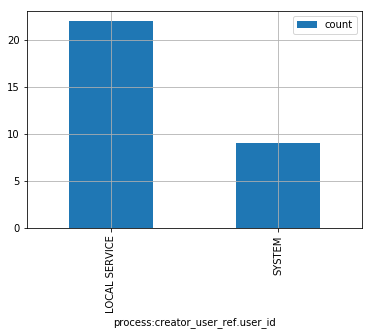

In [13]:
df1_bar.plot.bar(x='process:creator_user_ref.user_id', y='count', grid=True)

# svctest.exe analysis for .bat scripts

In [14]:
# Total number of SVCTEST executions of a .bat file
len(df1[df1['cmdline_bat'] != ''].index)

0

In [15]:
# .bat file executions grouped by process:creator_user_ref.user_id (username)/cmdline_bat and sorted by occurrence
df1[df1['cmdline_bat'] != '']\
    .groupby(['process:creator_user_ref.user_id','cmdline_bat'])\
    .size().reset_index(name='count')\
    .sort_values(['count'], ascending=False)

,process:creator_user_ref.user_id,cmdline_bat,count


# svctest.exe analysis for non-.bat script executions

In [16]:
# non-.bat PSExec executions grouped by process:creator_user_ref.user_id (username) and sorted by occurrence
df1[df1['cmdline_bat'] == '']\
    .groupby(['process:creator_user_ref.user_id'])\
    .size().reset_index(name='count')\
    .sort_values(['count'], ascending=False)

,process:creator_user_ref.user_id,count
0,LOCAL SERVICE,22
1,SYSTEM,9


In [17]:
# non-.bat SVCTEST executions (ungrouped)
df1[df1['cmdline_bat'] == ''][['process:creator_user_ref.user_id','cmdline','cmdline_host','duration', 'id']]\
    .sort_values(['process:creator_user_ref.user_id'], ascending=False)

,process:creator_user_ref.user_id,cmdline,cmdline_host,duration,id
0,SYSTEM,C:\File\System\svctest.exe -k netsvcs -p -s BITS,,0d 0h 0m 0.0s,observed-data--b7767318-6cca-4cf8-9280-826ed5f...
0,SYSTEM,C:\File\System\svctest.exe -k netsvcs -p -s BITS,,0d 0h 0m 0.0s,observed-data--6d07a6bd-377c-4594-9750-571b1e5...
0,SYSTEM,C:\File\System\svctest.exe -k netsvcs -p -s BITS,,0d 0h 0m 0.0s,observed-data--7bf4f251-1742-4013-957a-cf23513...
0,SYSTEM,C:\File\System\svctest.exe -k netsvcs -p -s BITS,,0d 0h 0m 0.0s,observed-data--0ab3f130-3666-4086-8d89-82fe88c...
0,SYSTEM,C:\File\System\svctest.exe -k netsvcs -p -s BITS,,0d 0h 0m 0.0s,observed-data--f70eced6-7991-4c47-b69c-18839ca...
0,SYSTEM,C:\File\System\svctest.exe -k netsvcs -p -s BITS,,0d 0h 0m 0.0s,observed-data--dd36ecb2-2b22-4620-a65c-fe4b62f...
0,SYSTEM,C:\File\System\svctest.exe -k netsvcs -p -s BITS,,0d 0h 0m 0.0s,observed-data--3d5fe0e1-300c-44b3-a6db-f96dd1a...
0,SYSTEM,C:\File\System\svctest.exe -k netsvcs -p -s BITS,,0d 0h 0m 0.0s,observed-data--2fe8daa7-94d1-4faa-aa87-363dc3a...
0,SYSTEM,C:\File\System\svctest.exe -k netsvcs -p -s BITS,,0d 0h 0m 0.0s,observed-data--87b274bc-358a-4a45-bb92-9471b95...
0,LOCAL SERVICE,C:\File\System\svctest.exe -k LocalServiceAndN...,,0d 0h 0m 0.0s,observed-data--c9b33025-d40f-4ecb-a7a2-c4dd237...


In [18]:
## Save and load DataFrame objects (to and from disk)

In [19]:
df1.to_pickle('df1.p')  # raw svctest processes (enhanced with cmdline_host and cmdline_bat
df2.to_pickle('df2.p')  # raw services service parent processes and children 

In [20]:
# Read pickle files into DataFrames
# df1 = pd.read_pickle('df1.p')
# df2 = pd.read_pickle('df2.p')


# Export to CSV

In [21]:
# Reindex and add missing fields
df1 = df1.reindex()
df2 = df2.reindex()

# Save to CSV
df1.to_csv("svctest-all-enhanced.csv", index=False)
df2.to_csv("services-all.csv", index=False)
